#### Goal: end-to-end simulation of LSSTxSO cross-correlation.

#### Focus here: uncorrelated galaxy modulation in CMB maps

Steps Implemented here:
1. Simulate an LSST catalog
    - Choose a halo catalog:
        * Look at the Rockstar halo catalog used in Takahashi sims (link below).
        * Downloaded `skyhalo_nres12r000.halo.gz`. Cleaned it up: keeping ['ID', 'Mvir', 'z_halo', 'theta_i', 'phi_i'] columns for galaxies with pid= -1.
            - Since the catalog is so big (40G), for now, read in chunks so that final sample (with cuts) contains about 10,000 galaxies.
    - Selection to match LSST redmagic
        * Implement cuts on Mvir: 5e12<Mvir<8e13
2. Populate galaxies on HP over-density map
    - Got orphics.catalog to work.
    - The galaxy sample is rather small rn. Need to get full catalog/a larger chunk to get more representative galaxy density map.
3. Covergence map from Takahashi sims
    - The format is weird: the binary file has data for convergence, shear1, shear2, and rotation. Looks like there are more entries in the array than needed for 4 healpix maps at nside= 4096.
4. LSST completeness map
    - Currently have read in estimated galaxy density data (deltaNByN) based on lsst depth variation.
    - Created a binary completeness map based on a completeness cutoff.
5. Create modulated galaxy density map and convergence map.
6. Cross-correlate maps
    i. True Cls: cross-correlation between the full-sky input convergence map with the full-sky halo density
        - Need to eventually be averaging over many realizations to get the simulation truth
    ii. cross-correlation between completeness x density and completeness x convergence, divided by fsky = (area of analysis mask)/(full sky area)
    iii. Repeat ii. after obtaining a smoothed halo density field 
        - Currently smoothed to gaussian with FWHM= 1 radian. Need to reduce it to 2 arcminutes or so. 
    iv. Repeat iii. after multiplying the smoothed halo density field by the completeness mask. 

###### Will run at higher HP resolution (and consider larger lmax) once have the full halo catalog.

Takahashi sims: http://cosmo.phys.hirosaki-u.ac.jp/takahasi/allsky_raytracing/nres12.html

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import os
import seaborn as sns

from collections import OrderedDict
import time

In [2]:
os.chdir('..')
home= os.getcwd()
print(home)

import sys
sys.path.insert(0, '%s/scripts')
from plots import plot_power_spectrum, plot_cls_dict


startTime= time.time()

/Users/Humna/repos/CMBL-LSS-CrossCorr


#### Define some params, file paths that are used in the analysis.

In [3]:
nside= 1024 #4096 #512 #256 #4096 # need match that from Takahashi sims to apply completeness mask
lmax= 1000 #3000 #1000

In [4]:
halocat_filepath= '%s/data/interm//finalOutput_10063gals.csv'%home
convergence_filepath= 'allskymap_nres12r000.zs66.mag.dat'

lsst_galaxycount_path= '/Volumes/Transcend/2016-09-09/artificialStructure_noPoissonNoise_nside256_14pixelRadiusForMasking_with0ptErrors_withDustExtinction_i<27.5_minion1016_fullSurveyPeriod_0.66<z<1.0_normalizedGalaxyCounts_directory/numGalData_afterBorderMasking_after0pt/numGalData_masked_with0pt_i_RandomDitherFieldPerVisit.npz'
lsst_completeness_path= '/Volumes/Transcend/2016-09-09/artificialStructure_noPoissonNoise_nside256_14pixelRadiusForMasking_with0ptErrors_withDustExtinction_i<27.5_minion1016_fullSurveyPeriod_0.66<z<1.0_normalizedGalaxyCounts_directory/deltaNByNData/deltaNByNData_masked_i_RandomDitherFieldPerVisit.npz'
runname, band, dither= 'minion1016', 'i', 'Random FPV'

completeness_threshold= -0.2 ## between -1, 1

In [5]:
# dictionary that will maps we care about
maps= {}

#### Read in the halo catalog. Plots some diagnostic plots.

In [6]:
halocat_data= pd.read_csv(halocat_filepath)
print(np.shape(halocat_data))
#data

(10063, 5)


In [7]:
#sns.pairplot(halocat_data)

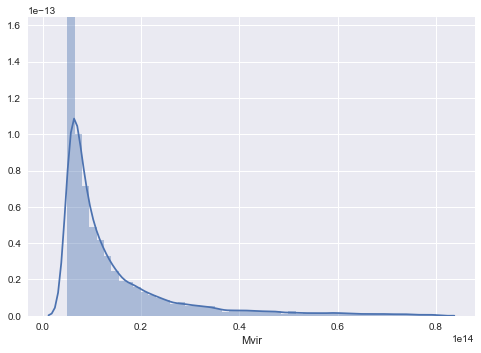

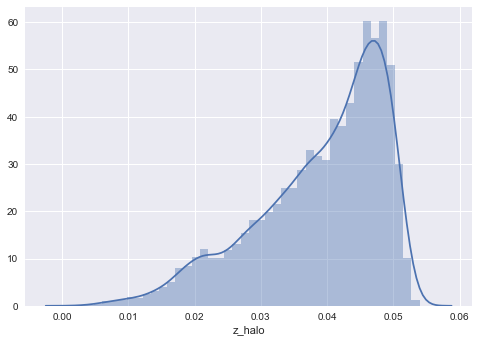

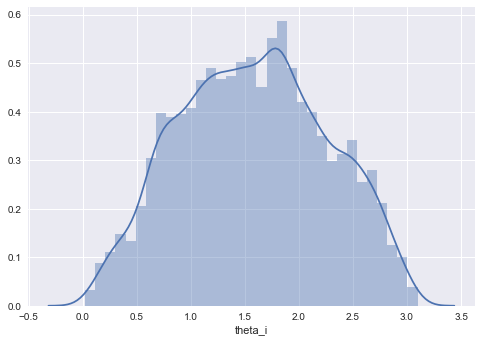

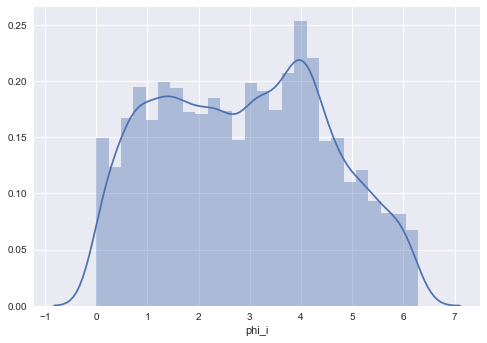

In [8]:
for key in halocat_data.keys()[1:]:
    sns.distplot(halocat_data[key])
    plt.show()

In [9]:
# add ra, dec columns based on theta, phi columns on the image plane
halocat_data['ra'], halocat_data['dec']= np.degrees(halocat_data['phi_i']), np.degrees(np.pi/2.0-halocat_data['theta_i'])

In [10]:
#halocat_data

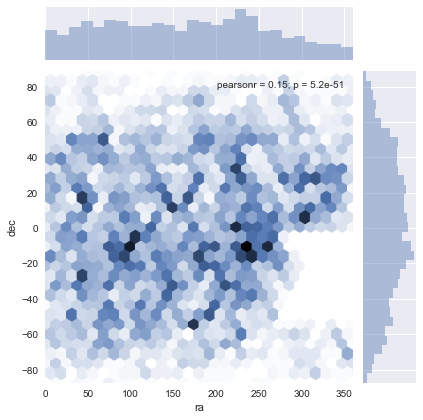

In [11]:
sns.jointplot(x= halocat_data['ra'], y= halocat_data['dec'], kind= 'hex')

In [12]:
#sns.jointplot(x= halocat_data['ra'], y= halocat_data['dec'], kind= 'kde')

#### Populate the galaxies on HP map

In [13]:
cambPath= '/Users/Humna/repos/CAMB/orphics/'
sys.path.insert(0, cambPath)

from orphics.catalogs import CatMapper
from enlib import enmap
from orphics import maps as omaps

In [14]:
%%time
print('Populating the halo catalog galaxies on an hp map with nside= %s'%nside)
halocat_catmap= CatMapper(ras_deg= halocat_data['ra'], decs_deg= halocat_data['dec'], nside= nside)

Populating the halo catalog galaxies on an hp map with nside= 1024
Calculating pixels...
Done with pixels...
Calculating histogram...
CPU times: user 449 ms, sys: 403 ms, total: 852 ms
Wall time: 1 s


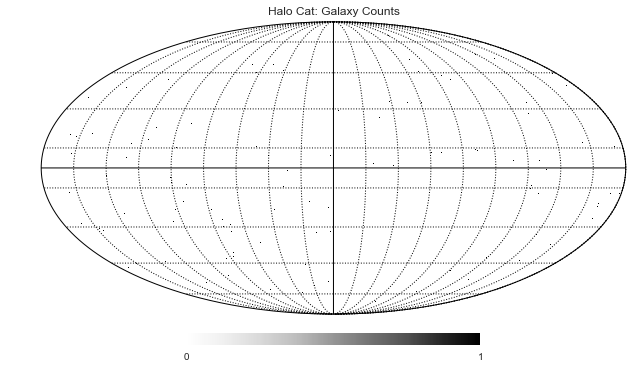

In [15]:
hp.mollview(halocat_catmap.counts, flip='astro', rot=(0,0,0), title= 'Halo Cat: Galaxy Counts')
hp.graticule(dpar=20, dmer=20, verbose=False)

The structure is rather sparse rn.

In [16]:
maps['halocat_delta'] = (halocat_catmap.counts/halocat_catmap.counts.mean())-1.

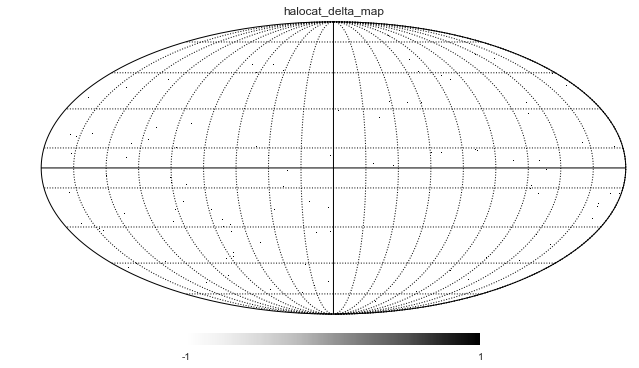

In [17]:
hp.mollview(maps['halocat_delta'] , flip='astro', rot=(0,0,0), min= -1, max= 1, title= 'halocat_delta_map')
hp.graticule(dpar=20, dmer=20, verbose=False)

In [18]:
print (halocat_catmap.counts.sum())
print (maps['halocat_delta'].sum())

10063.0
0.36084


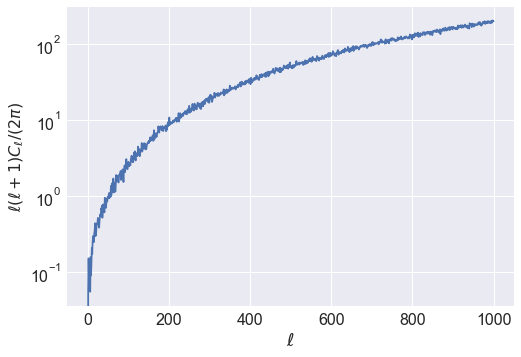

CPU times: user 12.1 s, sys: 374 ms, total: 12.5 s
Wall time: 12.6 s


In [19]:
%%time
# power spectrum of the overdensity
plot_power_spectrum(mapIn= maps['halocat_delta'], lmax= lmax, returnCls= False)

ok ..

In [20]:
#### Read in the lensed cmb maps from Takahashi
#filename= 'lensed_cmbmap_betazero_nres12r000.fits'
#hmap= hp.read_map('%s/data/%s'%(home, filename))

#hp.mollview(hmap., flip='astro', rot=(0,0,0))#, title= 'modulated galaxy counts')
#hp.graticule(dpar=20, dmer=20, verbose=False)

#### Read in the convergence map (+shear, etc) from Takahashi

In [21]:
%%time
datain = open('%s/data/%s'%(home, convergence_filepath),'rb')

nres = np.fromfile(datain, count=1, dtype=np.int32)[0] # nside= 2^nres
wl_data = np.fromfile(datain, dtype=np.float32)
datain.close()

CPU times: user 3.51 ms, sys: 6.83 s, total: 6.83 s
Wall time: 34.2 s


In [22]:
# order of things based on the provided Fortran code that's supposed to help read in the file
# http://cosmo.phys.hirosaki-u.ac.jp/takahasi/allsky_raytracing/dat2fits.f90
npix= hp.nside2npix(nside=2**nres)
print(npix)

print(len(wl_data))
print(4*npix)

201326592
805306380
805306368


!!!!! Weird: there are more entries in the .dat file than for 4 healpix maps!?!?!?!

In [23]:
wldata= OrderedDict()
wldata['kmap']= wl_data[0:npix]
wldata['shear1']= wl_data[npix:2*npix]
wldata['shear2']= wl_data[2*npix:3*npix]
wldata['rotation']= wl_data[3*npix:4*npix]

In [24]:
# check to make sure the maps are of the same len
for key in wldata:
    print('%s: %s npixels'%(key, len(wldata[key])))

kmap: 201326592 npixels
shear1: 201326592 npixels
shear2: 201326592 npixels
rotation: 201326592 npixels


kmap


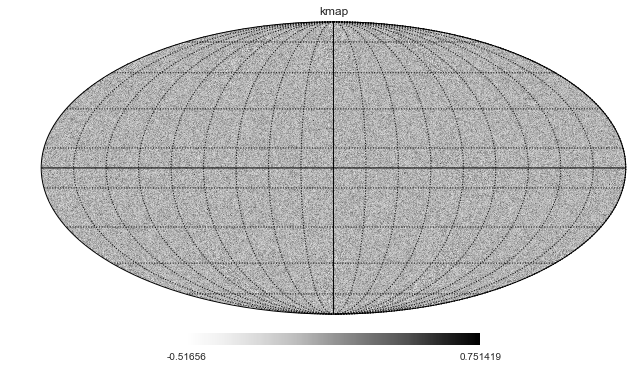

shear1


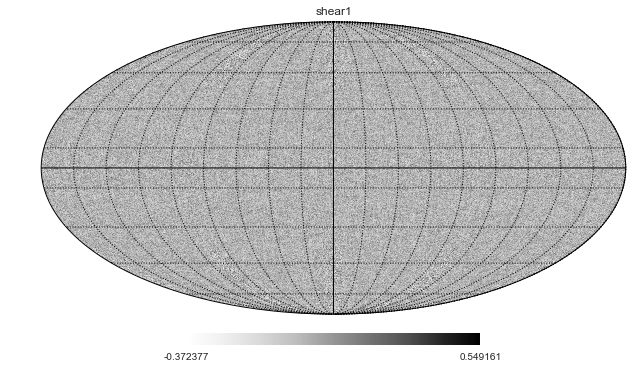

shear2


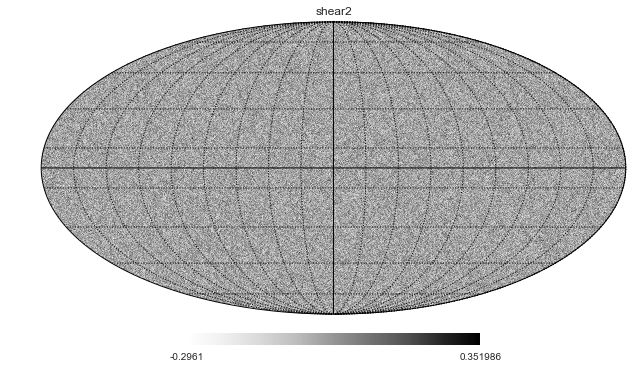

rotation


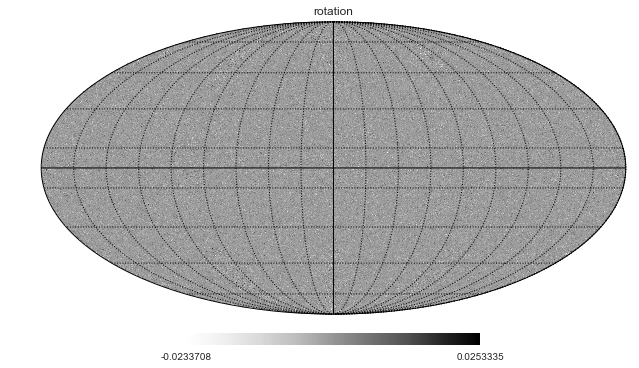

CPU times: user 4.61 s, sys: 2.12 s, total: 6.74 s
Wall time: 17.9 s


In [25]:
%%time
for key in wldata:
    print key
    hp.mollview(wldata[key], flip='astro', rot=(0,0,0), title= key)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.show()

In [26]:
maps['convergence'] = wldata['kmap']

#### Read in estimated overdensity data generated based on variations in depth;
nside= 256; i<27.5; with photometric calibration errors and dust extinction; 0.66<z<1.0

In [27]:
lsst_completeness= np.load(lsst_completeness_path)

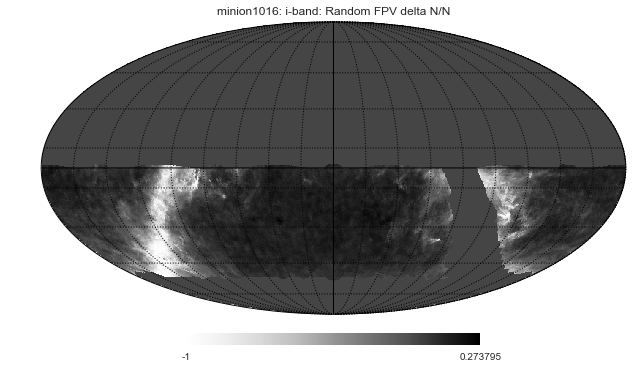

In [28]:
hp.mollview(lsst_completeness['metricValues'], flip='astro', rot=(0,0,0),
            title= '%s: %s-band: %s delta N/N'%(runname, band, dither))
hp.graticule(dpar=20, dmer=20, verbose=False)

#### Construct a completeness map based on the lsst 

In [29]:
maps['lsst_completeness']= np.zeros(len(lsst_completeness['metricValues']))
ind= np.where((lsst_completeness['metricValues']> completeness_threshold) &
              (lsst_completeness['mask']== False))[0]
maps['lsst_completeness'][ind]= 1.

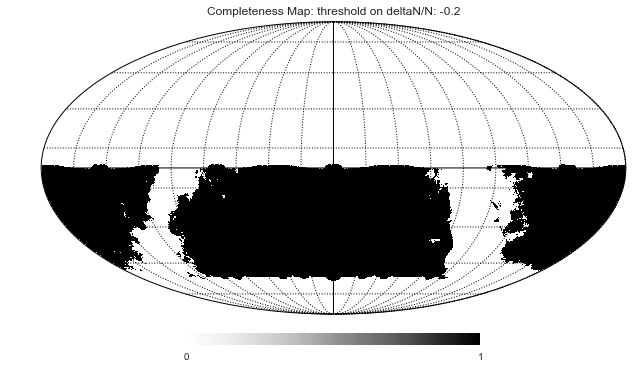

In [30]:
hp.mollview(maps['lsst_completeness'], flip='astro', rot=(0,0,0),
            title= 'Completeness Map: threshold on deltaN/N: %s'%completeness_threshold)
hp.graticule(dpar=20, dmer=20, verbose=False)

Converting the completness map from nside= 256 to nside= 1024
CPU times: user 1.49 s, sys: 509 ms, total: 2 s
Wall time: 2.41 s


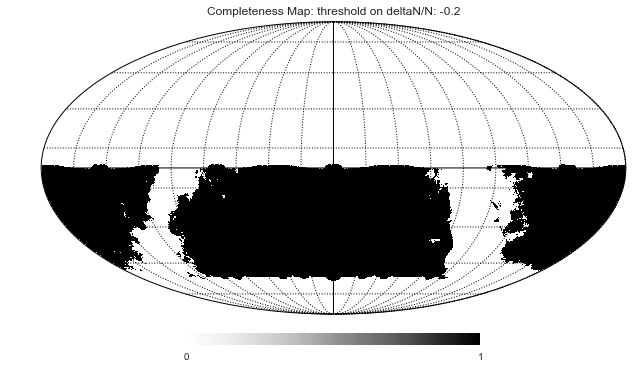

In [31]:
%%time
# match up the nside with Takahashi output
comp_nside= hp.npix2nside(lsst_completeness['slicerShape'])
if (comp_nside!=nside):
    print('Converting the completness map from nside= %s to nside= %s'%(comp_nside, nside))
    maps['lsst_completeness']= hp.ud_grade(map_in= maps['lsst_completeness'],
                                    nside_out= nside)
    
    hp.mollview(maps['lsst_completeness'], flip='astro', rot=(0,0,0),
            title= 'Completeness Map: threshold on deltaN/N: %s'%completeness_threshold)
    hp.graticule(dpar=20, dmer=20, verbose=False)

#### Modulate the halo catalog map and the convergence map with the completeness map

In [32]:
maps.keys()

['halocat_delta', 'convergence', 'lsst_completeness']

In [33]:
# for now
for key in maps.keys():
    print('Changing %s map resolution to nside= %s'%(key, nside))
    maps[key]= hp.ud_grade(maps[key], nside)

Changing halocat_delta map resolution to nside= 1024
Changing convergence map resolution to nside= 1024
Changing lsst_completeness map resolution to nside= 1024


In [34]:
maps['halocat_delta_modulated']= maps['halocat_delta']*maps['lsst_completeness']
maps['convergence_modulated']= maps['convergence']*maps['lsst_completeness']

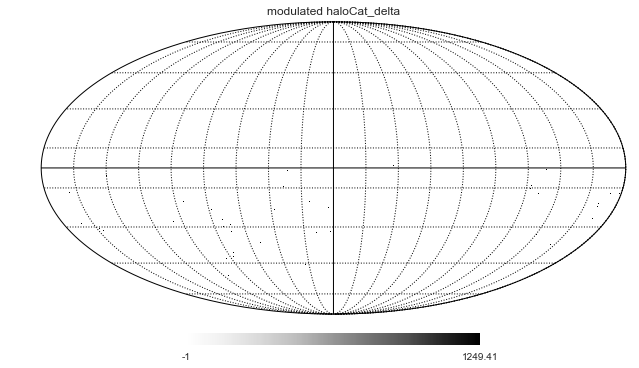

In [35]:
hp.mollview(maps['halocat_delta_modulated'], flip='astro', rot=(0,0,0), title= 'modulated haloCat_delta')
hp.graticule(dpar=20, dmer=20, verbose=False)

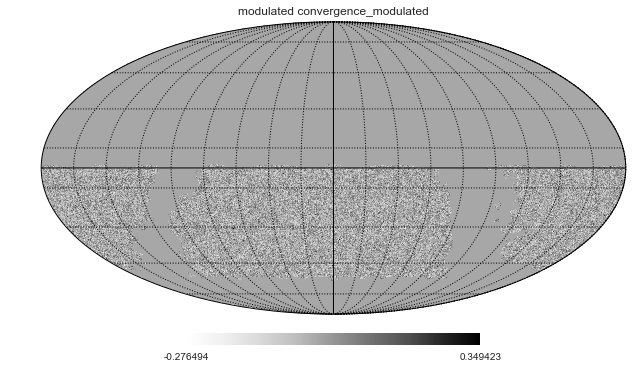

In [36]:
hp.mollview(maps['convergence_modulated'], flip='astro', rot=(0,0,0), title= 'modulated convergence_modulated')
hp.graticule(dpar=20, dmer=20, verbose=False)

#### Power spectra
1. True Cls: Cross-correlate the full-sky input convergence map with the full-sky halo density delta = ( Ngals - nmean) /nmean
    - Need to eventually be averaging over many realizations to get the simulation truth
2. cross-correlate completness x density and completeness x convergence, and divide by fsky = (area of analysis mask)/(full sky area)
    - Compare to True Cls. This tests whether you can obtain the correct Cls by only observing in a fraction of the sky when there are no galactic modulation effects in either data set.
3. Repeat 2 after obtaining a smoothed halo density field (say smoothed to gaussian with FWHM 2 arcminutes or so). 
    - This should also be close to True Cls but might differ at small scales you don't care about.
4. Repeat 3 after multiplying the smoothed halo density field by the completeness mask. 
    - Compare to True Cls. This will show what the bias is from having uncorrected Galaxy modulation in the LSST data set assuming perfect noiseless CMB lensing.

In [37]:
maps.keys()

['halocat_delta',
 'convergence',
 'lsst_completeness',
 'halocat_delta_modulated',
 'convergence_modulated']

In [38]:
%%time
cls= {}
cls['True: halocat_delta x convergence']= hp.anafast(maps['halocat_delta'], maps['convergence'], lmax= lmax)

CPU times: user 22.7 s, sys: 642 ms, total: 23.4 s
Wall time: 24 s


In [39]:
%%time
fsky= float(len(lsst_completeness['mask'][lsst_completeness['mask']==False]))/len(lsst_completeness['metricValues'])
print('fsky: %s'%fsky)
cls['halocat_delta_modulated x convergence_modulated']= hp.anafast(maps['halocat_delta_modulated'], maps['convergence_modulated'], lmax= lmax)/fsky

fsky: 0.394568125407
CPU times: user 22.1 s, sys: 594 ms, total: 22.7 s
Wall time: 23.1 s


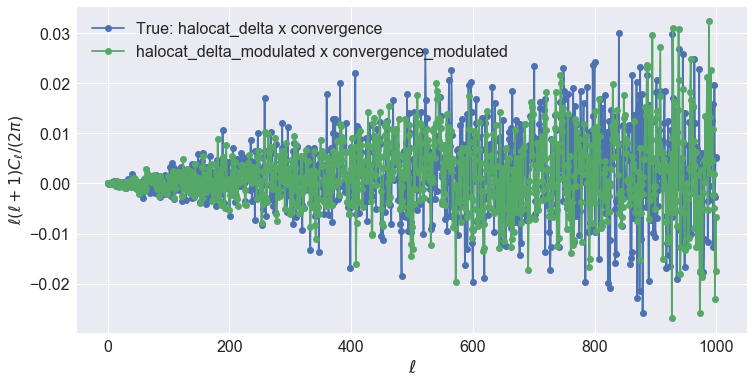

CPU times: user 824 ms, sys: 338 ms, total: 1.16 s
Wall time: 1.31 s


In [40]:
%%time
plot_cls_dict(cls)

In [41]:
%%time
maps['halocat_delta_smoothed']= hp.smoothing(maps['halocat_delta'], fwhm= .5) #np.radians(2/60.))
maps['halocat_delta_smoothed_modulated']= maps['halocat_delta']*maps['lsst_completeness']

Sigma is 729.938319 arcmin (0.212330 rad) 
-> fwhm is 1718.873385 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
CPU times: user 1min 18s, sys: 1.93 s, total: 1min 20s
Wall time: 1min 27s


In [42]:
%%time
cls['halocat_delta_smoothed x convergence']= hp.anafast(maps['halocat_delta_smoothed'], maps['convergence'], lmax= lmax)
cls['halocat_delta_smoothed_modulated x convergence_modulated']= hp.anafast(maps['halocat_delta_smoothed_modulated'],
                                                                            maps['convergence_modulated'],
                                                                            lmax= lmax)/fsky

CPU times: user 43.3 s, sys: 956 ms, total: 44.3 s
Wall time: 44.6 s


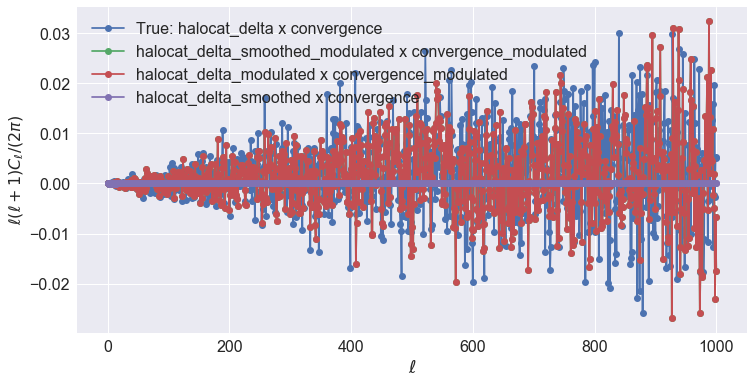

CPU times: user 667 ms, sys: 76.8 ms, total: 744 ms
Wall time: 759 ms


In [43]:
%%time
plot_cls_dict(cls)

In [44]:
print('Time taken for the entire thing: %s min'%((time.time()-startTime)/60.))

Time taken for the entire thing: 5.14497711658 min


5. The next step would be to repeat 1, but by replacing the input convergence map with a "reconstruction" from the lensed CMB map.The reconstruction can be obtained from a code like LensRecon.f90 in lenspix if you provide it a lensed CMB map. This should broadyly agree with True Cls. It might differ by 10-15% on large scales due to estimator releated effects. If it does, we can table those issues and treat the new Cls as your True Cls. (this is equivalent to saying that the estimator related multiplicative biases can be calibrated out using simple simulations)
and then repeat steps 2,3,4 with the new reconstruction and the new True Cls.
once we have finished all that (phew), we can start adding dust to the CMB maps